# 598RL HW5

In [1]:
#import basic packages
from IPython.display import clear_output
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import gym
import gridworld

params_ = {}
env = gym.make('GridWorld-v0')

### Set level to  the "easy" version of grid_world (actions deterministically move the agent) or the "hard" version (some probability of moving in a direction different to the desired action)

In [2]:
set_level = 'easy'

## REINFORCE code:

In [3]:
def get_state_row(curr_state, gridmap):
    
    state_row = curr_state[0]*len(gridmap[0]) + curr_state[1]
    return state_row

def REINFORCE_get_action(s, policy):
    
    policy_a = np.exp(policy[s,:]) / np.sum(np.exp(policy[s,:]), axis=0)
    a = np.random.choice(np.arange(policy.shape[1]), 1, replace=False, p=policy_a)
    return int(a), np.log(policy_a[a])

def REINFORCE_get_trajectory(T, policy):
    
    states, actions, rewards= np.zeros([T], dtype=int), np.zeros([T], dtype=int), np.zeros([T], dtype=int)
    log_probs = np.zeros([T])
    
    s = env.reset(set_level)
    states[0] = get_state_row(s, env.GRIDMAP)
    
    for t in range(T):
                
        actions[t], log_probs[t] = REINFORCE_get_action(states[t], policy)
        s, rewards[t], _, _ = env.step(env.action_str[actions[t]])
        
        if t!=T-1:
            states[t+1] = get_state_row(s, env.GRIDMAP)
    
    return states, actions, rewards, log_probs

def REINFORCE_get_gradient(s, a, policy):
    
    dJ = np.zeros(policy.shape)
    policy_a = np.exp(policy[s,:]) / np.sum(np.exp(policy[s,:]), axis=0)
    
    dJ[s,:] = -policy_a[a]
    dJ[s,a] = 1 - policy_a[a]
    
    return dJ

def REINFORCE_get_likelihood(s, a, policy):
    
    policy_a = np.exp(policy[s,:]) / np.sum(np.exp(policy[s,:]), axis=0)
    return np.log(policy_a[a])

def init_traj_memory(traj_m_len, T, policy):
    
    traj_m = {}
    traj_m['states'] = []
    traj_m['actions'] = []
    traj_m['log_probs'] = []
    traj_m['rewards'] = []
    traj_m['policy_idx'] = []

    for i in range(traj_m_len):
        s, a, r, log_prob =  REINFORCE_get_trajectory(T, policy)
        traj_m['states'].append(s)
        traj_m['actions'].append(a)
        traj_m['rewards'].append(r)
        traj_m['log_probs'].append(log_prob)
        traj_m['policy_idx'].append(0)
        
    return traj_m
        
def add_traj_memory(traj_m, b_s, T, policy, p_idx):
    
    for i in range(b_s):
        traj_m['states'].pop(0)
        traj_m['actions'].pop(0)
        traj_m['rewards'].pop(0)
        traj_m['log_probs'].pop(0)
        traj_m['policy_idx'].pop(0)
        s, a, r, log_prob =  REINFORCE_get_trajectory(T, policy)
        traj_m['states'].append(s)
        traj_m['actions'].append(a)
        traj_m['rewards'].append(r)
        traj_m['log_probs'].append(log_prob)
        traj_m['policy_idx'].append(p_idx)
        
    return traj_m

def REINFORCE_get_baseline(T, traj_m_len, traj_rewards):
    
    b = np.zeros([T])
    for n in range(traj_m_len):
        for t in range(T):
            b[t] += np.sum(traj_rewards[n][t:]) / traj_m_len
    
    return b

def policy_gradient(params):

    n_action = len(env.action_str)
    n_states = len(env.GRIDMAP[0]) * len(env.GRIDMAP)
    
    n_eps, episode_length = params['n_eps'], params['episode_length']
    batch_size = params['batch_size']
    lr = params['lr']
    traj_mem_len = params['traj_mem_len']    
    IS_, C_, BS_ = params['importance_sampling'], params['causality'], params['baseline_shift']

    n_batches = int( n_eps / batch_size)
    policy_ = np.ones((n_states,n_action))
    
    policy_memory = []
    policy_memory.append(policy_)
    
    traj_memory = init_traj_memory(traj_mem_len, episode_length, policy_)
    
    reward_array = []
    
    for batch in range(n_batches):

        traj_memory = add_traj_memory(traj_memory, batch_size, episode_length, policy_, batch)
        if BS_ is True:
            baseline = REINFORCE_get_baseline(episode_length, traj_mem_len, traj_memory['rewards'])
        else:
            baseline = np.zeros([episode_length])
        
        if IS_ is True:
            traj_idx = np.random.choice(traj_mem_len, batch_size)
        else:
            traj_idx = np.arange(traj_mem_len-batch_size, traj_mem_len)
            
        J_grad = np.zeros(policy_.shape)
        reward_avg = 0
        batch_count = 0
        ratio_array = []
        
        E_samples = np.empty((n_states,n_action,batch_size))
        
        for n in range(batch_size):

            s = traj_memory['states'][traj_idx[n]]
            a = traj_memory['actions'][traj_idx[n]]
            r = traj_memory['rewards'][traj_idx[n]]
            lp = traj_memory['log_probs'][traj_idx[n]]
            policy_idx = traj_memory['policy_idx'][traj_idx[n]]
            
            E_term = np.zeros(policy_.shape)
            lp_n, lp_d = 0.0, 0.0
            for t in range(episode_length):
                #update the gradient
                if C_ is True:
                    E_term += REINFORCE_get_gradient(s[t], a[t], policy_memory[policy_idx])*(np.sum(r[t:])-baseline[t])
                else:
                    E_term += REINFORCE_get_gradient(s[t], a[t], policy_memory[policy_idx])*(np.sum(r)-baseline[0])
                lp_n += lp[t]
                lp_d += REINFORCE_get_likelihood(s[t], a[t], policy_)
                
            likelihood_ratio = np.exp(lp_n) / np.exp(lp_d)
            if likelihood_ratio > 200.0:
                continue
            batch_count += 1
            
            ratio_array.append(likelihood_ratio)

            current_sample = likelihood_ratio * (E_term)
            E_samples[:,:,n] = current_sample
            J_grad += current_sample
            reward_avg += np.sum(r)
            
        J_grad /= batch_count
        reward_avg /= batch_count
                
        #update policy        
        reward_array.append(reward_avg / episode_length)
        policy_ = policy_ + lr * J_grad
        
        policy_memory.append(policy_)
            
    return np.arange(n_batches)*batch_size, reward_array, E_samples

In [4]:
params_.update({'n_eps': 3000, 'episode_length': 20, 'batch_size': 100, 'lr': 0.1, 'traj_mem_len': 300})

params_.update({'importance_sampling': False, 'causality': False, 'baseline_shift': False})
pg1_x, pg1_y, samples1 = policy_gradient(params_)
params_.update({'importance_sampling': True, 'causality': False, 'baseline_shift': False})
pg2_x, pg2_y, samples2 = policy_gradient(params_)
params_.update({'importance_sampling': False, 'causality': True, 'baseline_shift': False})
pg3_x, pg3_y, samples3 = policy_gradient(params_)
params_.update({'importance_sampling': False, 'causality': False, 'baseline_shift': True})
pg4_x, pg4_y, samples4 = policy_gradient(params_)
params_.update({'importance_sampling': False, 'causality': True, 'baseline_shift': True})
pg5_x, pg5_y, samples5 = policy_gradient(params_)
params_.update({'importance_sampling': True, 'causality': False, 'baseline_shift': True})
pg6_x, pg6_y, samples6 = policy_gradient(params_)
params_.update({'importance_sampling': True, 'causality': True, 'baseline_shift': False})
pg7_x, pg7_y, samples7 = policy_gradient(params_)

### Compare the learning speed (number of episodes) to your implementation of REINFORCE from last week. Do the three changes result in faster or slower convergence? Do they result in a better agent?

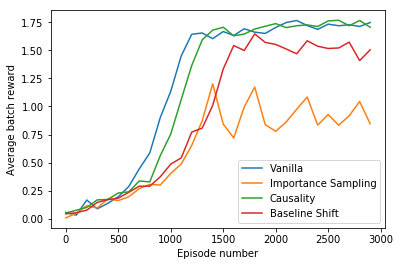

In [5]:
plt.plot(pg1_x, pg1_y, label='Vanilla')
plt.plot(pg2_x, pg2_y, label='Importance Sampling')
plt.plot(pg3_x, pg3_y, label='Causality')
plt.plot(pg4_x, pg4_y, label='Baseline Shift')
plt.xlabel('Episode number')
plt.ylabel('Average batch reward')
plt.legend()
plt.show()

The vanilla REINFORCE seems to perform best in terms of learning speed for this set of hyperparameters.

### Also, compare the sample variance of the policy gradient. Verify that "causality" and "baseline shift" reduce the sample variance. (Does importance sampling have an effect on the sample variance?)

In [6]:
print('Average variance in last batch of samples')
print('Vanilla:', np.mean(np.var(samples1, axis=-1)))
print('Importance Sampling:', np.mean(np.var(samples2, axis=-1)))
print('Causality:', np.mean(np.var(samples3, axis=-1)))
print('Baseline Shift:', np.mean(np.var(samples4, axis=-1)))

Average variance in last batch of samples
Vanilla: 1680.8026959299336
Importance Sampling: 852.4493448201898
Causality: 498.28288660618665
Baseline Shift: 100.15730194865534


Causality and baseline shift seem to conistently reduce sample variance. Importance sampling randomly increases or decreases the sample variance.

### Include an ablation study in your analysis, where you test the algorithm three times, with one feature removed each time (e.g., with only importance sampling and baseline shift), to quantify the impact of this feature on performance.

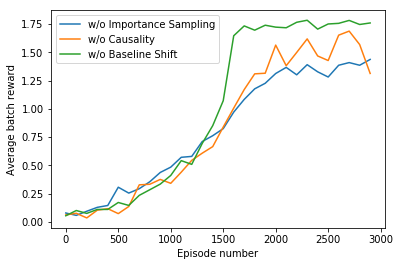

In [7]:
plt.plot(pg5_x, pg5_y, label='w/o Importance Sampling')
plt.plot(pg6_x, pg6_y, label='w/o Causality')
plt.plot(pg7_x, pg7_y, label='w/o Baseline Shift')
plt.xlabel('Episode number')
plt.ylabel('Average batch reward')
plt.legend()
plt.show()

The algorithm seems to work best without the baseline shift feature.